Debe de ser corrido en un entorno Linux

## Paso 1: Instalar las dependencias y configurar el proyecto en GPU


In [1]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2943  100  2943    0     0   7442      0 --:--:-- --:--:-- --:--:--  7431
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.la

In [2]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tensorflow-model-server is already the newest version (2.13.0).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [3]:
#!pip install tensorflow-gpu==1.13.1

In [4]:
!pip install requests

## Paso 2: Importar las dependencias del proyecto

In [5]:
import os
import json
import random
import requests
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

%matplotlib inline
tf.__version__

'2.12.0'

## Paso 3: Pre procesado de los datos

### Cargar el dataset

In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [7]:
class_names = ['avión', 'coche', 'pájaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión']

### Normalización de imágenes

In [8]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [9]:
X_train.shape

(50000, 32, 32, 3)

## Paso 4: Definir el modelo

NOTA: Vamos a usar el mismo modelo que creamos en la Sección de Redes Neuronales Convolucionales

In [37]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

### Compilar el modelo

In [38]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

###  Entrenar el modelo

In [39]:
model.fit(X_train,
          y_train,
          batch_size=128,
          epochs=100)

Epoch 1/100
391/391 [==============================] - 8s 12ms/step - loss: 1.6971 - sparse_categorical_accuracy: 0.3614
Epoch 2/100
391/391 [==============================] - 5s 12ms/step - loss: 1.2199 - sparse_categorical_accuracy: 0.5549
Epoch 3/100
391/391 [==============================] - 5s 12ms/step - loss: 0.9686 - sparse_categorical_accuracy: 0.6550
Epoch 4/100
391/391 [==============================] - 5s 12ms/step - loss: 0.8107 - sparse_categorical_accuracy: 0.7140
Epoch 5/100
391/391 [==============================] - 5s 12ms/step - loss: 0.6933 - sparse_categorical_accuracy: 0.7581
Epoch 6/100
391/391 [==============================] - 5s 12ms/step - loss: 0.5951 - sparse_categorical_accuracy: 0.7930
Epoch 7/100
391/391 [==============================] - 5s 12ms/step - loss: 0.5064 - sparse_categorical_accuracy: 0.8215
Epoch 8/100
391/391 [==============================] - 5s 12ms/step - loss: 0.4398 - sparse_categorical_accuracy: 0.8438
Epoch 9/100
391/391 [===========

### Evaluar el modelo

In [40]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.5277 - sparse_categorical_accuracy: 0.7902


In [41]:
print("La precisión del modelo es de {} %".format(test_accuracy*100.0))

La precisión del modelo es de 79.01999950408936 %


## Paso 5: Guardar el modelo para subir a producción

### Crear un directorio para el modelo

In [42]:
MODEL_DIR = "model/"
version = 1

In [43]:
export_path = os.path.join(MODEL_DIR, str(version))
export_path

'model/1'

In [44]:
if os.path.isdir(export_path):
    !rm -r {export_path}

### Guardar el modelo para TensorFlow Serving

In [45]:
#tf.saved_model.simple_save(tf.keras.backend.get_session(), export_dir=export_path, inputs={"input_image":model.input}, outputs={t.name:t for t in model.outputs})
#tf.saved_model.save(model, export_path )
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = model/1




Saved model:
total 376
drwxr-xr-x 2 root root   4096 Aug  8 01:08 assets
-rw-r--r-- 1 root root     55 Aug  8 01:08 fingerprint.pb
-rw-r--r-- 1 root root  33280 Aug  8 01:08 keras_metadata.pb
-rw-r--r-- 1 root root 335792 Aug  8 01:08 saved_model.pb
drwxr-xr-x 2 root root   4096 Aug  8 01:08 variables


## Paso 6: Configurar el entorno de producción

### Exportar el MODEL_DIR a las variables de entorno

In [46]:
os.environ['MODEL_DIR'] = os.path.abspath(MODEL_DIR)

### Ejecutar la API REST de TensorFlow Serving

In [47]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8000 \
  --model_name=cifar10 \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [48]:
!tail server.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


## Paso 7: Crear nuestra primera petición por POST

In [49]:
random_image = np.random.randint(0, len(X_test))
random_image

3998

### Crear el objeto de datos en JSON

In [50]:
data = json.dumps({"signature_name":"serving_default", "instances":[X_test[random_image].tolist()]})#Servidor por defecto,Imagenes en string

In [51]:
data

'{"signature_name": "serving_default", "instances": [[[[0.4745098039215686, 0.43529411764705883, 0.4235294117647059], [0.4470588235294118, 0.4117647058823529, 0.38823529411764707], [0.4470588235294118, 0.40784313725490196, 0.403921568627451], [0.5019607843137255, 0.4549019607843137, 0.47058823529411764], [0.5607843137254902, 0.5137254901960784, 0.5294117647058824], [0.5686274509803921, 0.5215686274509804, 0.5254901960784314], [0.5372549019607843, 0.49411764705882355, 0.49019607843137253], [0.5254901960784314, 0.47843137254901963, 0.4627450980392157], [0.5215686274509804, 0.4666666666666667, 0.42745098039215684], [0.49019607843137253, 0.4392156862745098, 0.4117647058823529], [0.5019607843137255, 0.4549019607843137, 0.45098039215686275], [0.5372549019607843, 0.4980392156862745, 0.5058823529411764], [0.4823529411764706, 0.45098039215686275, 0.45098039215686275], [0.36470588235294116, 0.3333333333333333, 0.3333333333333333], [0.2901960784313726, 0.27058823529411763, 0.2784313725490196], [0

### Enviar la primera petición POST al modelo

In [52]:
headers = {"content-type":"application/json"}

In [53]:
json_response = requests.post(url="http://localhost:8000/v1/models/cifar10:predict", data=data, headers=headers)

In [54]:
json_response

<Response [200]>

In [55]:
predictions = json.loads(json_response.text)['predictions']

In [56]:
predictions

[[1.92827338e-06,
  1.63173608e-09,
  0.903275073,
  3.31582123e-05,
  0.000100700163,
  0.0959045365,
  0.00067151984,
  1.25516135e-05,
  6.89692783e-08,
  4.22923421e-07]]

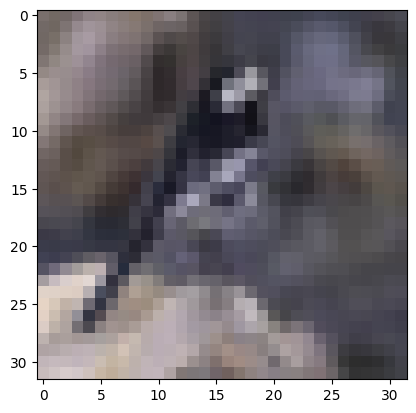

In [57]:
plt.imshow(X_test[random_image])

In [58]:
class_names[np.argmax(predictions[0])]

'pájaro'

## Paso 8: Enviar una petición POST a un modelo específico



In [59]:
specific_json_response = requests.post(url="http://localhost:8000/v1/models/cifar10/versions/1:predict", data=data, headers=headers)

In [60]:
specific_json_response

<Response [200]>

## Paso 9: Test


In [61]:
import imageio
image = imageio.imread("ca.png")

<ipython-input-61-c12b937e67d9>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread("ca.png")


In [62]:
data = json.dumps({"signature_name":"serving_default", "instances":[image.tolist()]})

In [63]:
headers = {"content-type":"application/json"}

In [64]:
json_response = requests.post(url="http://localhost:8000/v1/models/cifar10:predict", data=data, headers=headers)

In [65]:
json_response

<Response [200]>

In [66]:
predictions = json.loads(json_response.text)['predictions']

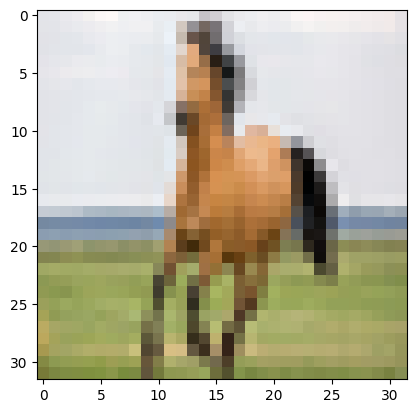

In [67]:
plt.imshow(image)

In [68]:
class_names[np.argmax(predictions[0])]

'caballo'